In [30]:
from os import path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from itertools import chain, combinations
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import SGD
from sklearn.datasets import make_blobs
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras import metrics
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import confusion_matrix
from itertools import product

# MLB Neural Network Model: Classifying Pitch Count
By Ayden Salazar

Features: TBD

Output: 'pitch_type'

In [20]:
mlb = pd.read_csv("data/michaels_mlb_cleaned_data.csv")
mlb.head(5)

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,b_count,s_count,pitch_num
0,-0.390,3.600,91.0,84.2,1972.614,190.202,7.1,3.4,23.8,-3.210,...,-1.77,9.82,53.0,11.0,B,B,FC,1.0,0.0,2.0
1,-0.005,2.257,85.9,80.4,41.087,214.714,-1.0,8.1,23.9,-0.203,...,-0.13,0.14,48.0,5.0,F,S,SL,0.0,0.0,1.0
2,0.820,3.193,94.1,86.7,2376.304,205.009,30.8,3.2,23.8,-9.536,...,-4.96,10.59,58.0,12.0,S,S,FF,2.0,1.0,4.0
3,-0.088,2.358,94.1,87.2,2504.011,216.915,41.2,4.1,23.8,-14.264,...,-7.38,9.78,25.0,5.0,E,X,FF,3.0,2.0,8.0
4,1.370,2.934,92.6,85.7,2235.653,204.604,26.4,3.5,23.8,-8.694,...,-4.64,10.10,24.0,12.0,B,B,FF,2.0,1.0,4.0


In [21]:
mlb.dtypes

px              float64
pz              float64
start_speed     float64
end_speed       float64
spin_rate       float64
spin_dir        float64
break_angle     float64
break_length    float64
break_y         float64
ax              float64
ay              float64
az              float64
p_throws         object
sz_bot          float64
sz_top          float64
pitcher_id        int64
batter_side      object
vx0             float64
vy0             float64
vz0             float64
x               float64
x0              float64
y               float64
y0              float64
z0              float64
pfx_x           float64
pfx_z           float64
nasty           float64
zone            float64
code             object
type             object
pitch_type       object
b_count         float64
s_count         float64
pitch_num       float64
dtype: object

**Step 1**: First I will one-hot encode all categorical feature columns. These columns are: 'p_throws', 'batter_side', and 'type' (Simplified pitch outcome codes, S (strike) B (ball) or X (in play)). Will DROP 'code' column due to not finding documentation describing the meaning behind it and type beind a simplification of it.

In [22]:
# one-hot encode the 'p_throws','batter_side','type' columns
mlb_oh = pd.get_dummies(data=mlb, columns=['p_throws','batter_side','type'])
mlb_oh.drop(['code', 'x', 'y'], axis=1, inplace=True)
mlb_oh = mlb_oh.loc[(mlb_oh['pitch_type'] != 'KC') &
          (mlb_oh['pitch_type'] != 'KN') & 
          (mlb_oh['pitch_type'] != 'FS')]
mlb_oh.head(3)


,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,b_count,s_count,pitch_num,p_throws_L,p_throws_R,batter_side_L,batter_side_R,type_B,type_S,type_X
0,-0.390,3.600,91.0,84.2,1972.614,190.202,7.1,3.4,23.8,-3.210,...,1.0,0.0,2.0,0,1,1,0,1,0,0
1,-0.005,2.257,85.9,80.4,41.087,214.714,-1.0,8.1,23.9,-0.203,...,0.0,0.0,1.0,0,1,0,1,0,1,0
2,0.820,3.193,94.1,86.7,2376.304,205.009,30.8,3.2,23.8,-9.536,...,2.0,1.0,4.0,0,1,0,1,0,1,0


In [23]:
str([1,2])

'[1, 2]'

In [24]:
mlb_oh['Balls, Strikes'] = mlb_oh[['b_count', 's_count']].values.tolist()
mlb_oh['Balls, Strikes'] = mlb_oh['Balls, Strikes'].astype(str)
mlb_oh = pd.get_dummies(data=mlb_oh, columns=['Balls, Strikes'])
mlb_oh.head(3)


,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,"Balls, Strikes_[1.0, 0.0]","Balls, Strikes_[1.0, 1.0]","Balls, Strikes_[1.0, 2.0]","Balls, Strikes_[2.0, 0.0]","Balls, Strikes_[2.0, 1.0]","Balls, Strikes_[2.0, 2.0]","Balls, Strikes_[3.0, 0.0]","Balls, Strikes_[3.0, 1.0]","Balls, Strikes_[3.0, 2.0]","Balls, Strikes_[4.0, 2.0]"
0,-0.390,3.600,91.0,84.2,1972.614,190.202,7.1,3.4,23.8,-3.210,...,1,0,0,0,0,0,0,0,0,0
1,-0.005,2.257,85.9,80.4,41.087,214.714,-1.0,8.1,23.9,-0.203,...,0,0,0,0,0,0,0,0,0,0
2,0.820,3.193,94.1,86.7,2376.304,205.009,30.8,3.2,23.8,-9.536,...,0,0,0,0,1,0,0,0,0,0


**Step 2:** Now, I will extract an X and y dataset and perform a train/test split on the data and normalize the features. Nothing but procedural stuff so far. 

In [25]:
X = mlb_oh.drop(['pitch_type', 'sz_bot', 'sz_top'], axis=1)
y = mlb_oh[['pitch_type']]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)
y = dummy_y
y

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [110]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

sc=preprocessing.MinMaxScaler()
X_train = sc.fit_transform(X_train)

sc=preprocessing.MinMaxScaler()
X_test = sc.fit_transform(X_test)

**Step 3:** Time to make a preliminary neural network model. As a form of initial analysis, I will create a naive neural network model that simply uses all the normalized features with no feature engineering to predict the target class. Let's see how well this performs.

In [111]:
len(mlb_oh['pitch_type'].unique())

7

In [112]:
# # define baseline model
# def baseline_model():
#     # create model
#     num_dim = X_train.shape[1]
#     model = Sequential()
#     model.add(Dense(8, input_dim=num_dim, activation='relu'))
#     model.add(Dense(7, activation='softmax'))
#     # Compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model
 
# estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=1000, verbose=0)
# kfold = KFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, X_train, y_train, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



In [118]:
num_dim = X_train.shape[1]

#Initilize ANN
classifier = Sequential()

#Add input layer and fitst hidden layer
classifier.add(Dense(50, activation='relu', kernel_initializer='uniform', input_dim = num_dim))


#Add second hidden layer
classifier.add(Dense(50, activation='relu', kernel_initializer='uniform'))

# #Add third hidden layer
# classifier.add(Dense(50, activation='relu', kernel_initializer='uniform'))

#Add oupt layer
#classifier.add(Dense(10, activation = tf.nn.softmax, kernel_initializer='uniform'))
classifier.add(Dense(7, activation = tf.nn.softmax, kernel_initializer='uniform'))

#compiling ANN
#classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [metrics.categorical_accuracy])

sgd = SGD(0.005, momentum=0.0, nesterov=False)
classifier.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

# Fitting the ANN to the Training set
model = classifier.fit(X_train, y_train, batch_size = 10, epochs = 25, validation_split=0.1)

Epoch 1/100
3306/3306 [==============================] - 4s 1ms/step - loss: 1.5951 - categorical_accuracy: 0.5025 - val_loss: 1.5183 - val_categorical_accuracy: 0.5105
Epoch 2/100
3306/3306 [==============================] - 4s 1ms/step - loss: 1.4352 - categorical_accuracy: 0.5031 - val_loss: 1.2354 - val_categorical_accuracy: 0.5105
Epoch 3/100
3306/3306 [==============================] - 4s 1ms/step - loss: 1.0599 - categorical_accuracy: 0.6314 - val_loss: 0.9030 - val_categorical_accuracy: 0.7512
Epoch 4/100
3306/3306 [==============================] - 4s 1ms/step - loss: 0.7995 - categorical_accuracy: 0.7572 - val_loss: 0.7331 - val_categorical_accuracy: 0.7806
Epoch 5/100
3306/3306 [==============================] - 4s 1ms/step - loss: 0.7082 - categorical_accuracy: 0.7747 - val_loss: 0.7892 - val_categorical_accuracy: 0.7433
Epoch 6/100
3306/3306 [==============================] - 4s 1ms/step - loss: 0.6825 - categorical_accuracy: 0.7807 - val_loss: 0.6768 - val_categorical_acc

KeyboardInterrupt: 

In [88]:
y_pred_softmax = classifier.predict(X_test)

y_pred = [np.argmax(i) for i in y_pred_softmax]

y_pred

[0,
 0,
 3,
 3,
 3,
 1,
 0,
 0,
 6,
 3,
 0,
 6,
 3,
 6,
 5,
 0,
 4,
 3,
 1,
 6,
 3,
 3,
 3,
 4,
 3,
 0,
 3,
 0,
 3,
 0,
 4,
 3,
 3,
 0,
 3,
 3,
 1,
 0,
 6,
 3,
 3,
 3,
 3,
 2,
 3,
 4,
 3,
 6,
 3,
 3,
 3,
 0,
 3,
 3,
 6,
 0,
 0,
 6,
 3,
 0,
 3,
 3,
 3,
 3,
 4,
 6,
 0,
 3,
 1,
 6,
 1,
 4,
 1,
 6,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 6,
 6,
 3,
 3,
 6,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 0,
 6,
 0,
 0,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 1,
 6,
 3,
 3,
 5,
 3,
 0,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 0,
 6,
 6,
 0,
 3,
 4,
 3,
 3,
 0,
 6,
 6,
 6,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 6,
 3,
 4,
 3,
 3,
 0,
 3,
 3,
 3,
 4,
 0,
 3,
 3,
 0,
 1,
 6,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 6,
 0,
 3,
 2,
 6,
 2,
 3,
 6,
 0,
 4,
 3,
 3,
 0,
 6,
 0,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 0,
 2,
 4,
 3,
 5,
 3,
 3,
 3,
 3,
 5,
 6,
 3,
 3,
 4,
 5,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 4,
 1,
 4,
 3,
 3,
 3,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 1,
 3,
 6,
 3,
 0,
 1,
 0,
 6,
 3,
 1,
 3,
 0,
 1,


In [89]:
encoded_Y

array([2, 6, 3, ..., 3, 5, 0])

In [31]:


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [91]:
y_test_numeric = np.argmax(y_test, axis=1)
y_test_numeric

array([0, 0, 3, ..., 3, 1, 0])

Confusion matrix, without normalization
[[1388    2    2   13   29   39    5]
 [   5 1058    0    0    0    0   62]
 [  13    0  246  142    5    1  112]
 [  19    0   18 5963  146    5    5]
 [  31    0    1  181  401  127    0]
 [  61    0    0  112  305  164    0]
 [  51   92   80   23    2    0 1333]]


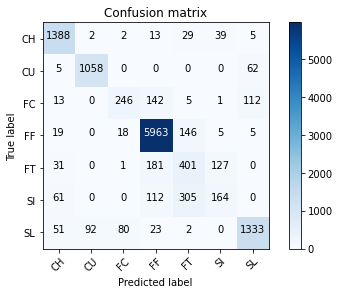

In [92]:
cm = confusion_matrix(y_true=y_test_numeric, y_pred=y_pred)
plot_confusion_matrix(cm, encoder.classes_,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)

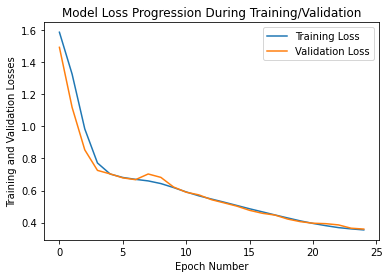

In [93]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])

plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [94]:
loss, accuracy = classifier.evaluate(X_train, y_train, verbose=0)
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

Accuracy: 0.870442
Loss: 0.350381


In [95]:
loss, accuracy = classifier.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

Accuracy: 0.862032
Loss: 0.379957


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


X = mlb_oh.drop(['pitch_type', 'sz_bot', 'sz_top'], axis=1)
y = mlb_oh[['pitch_type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


clf = DecisionTreeClassifier(random_state=0)

bag = BaggingClassifier(base_estimator=clf,
                      n_estimators=10, random_state=0).fit(X_train, y_train)



/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
bag.score(X_train, y_train)

0.9956160653505787

In [28]:
bag.score(X_test, y_test)

0.9058160431302075

Confusion matrix, without normalization
[[1409    4    8    8   14   16   19]
 [   0 1058    0    0    0    0   67]
 [   9    1  361   53    2    2   91]
 [  19    0   51 5975   77   31    3]
 [  22    0    3  167  489   58    2]
 [  34    0    4   84  129  390    1]
 [  15   64   83    8    2    2 1407]]


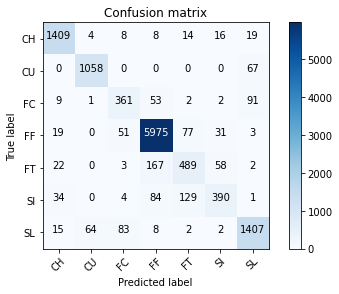

In [32]:
y_pred = bag.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, encoder.classes_,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)